<a href="https://colab.research.google.com/github/zasminah/Python_MachineLearning/blob/main/NLP_sentiment_analysis_korean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Korean NLP sentiment analysis using KoNLPy**

In [35]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
+ bash -x
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
from bs4 import BeautifulSoup
import urllib.request
from konlpy.tag import Mecab

**Data**
For simple, get text file of Naver movie review from github instead of Web crawling

https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [37]:
ratings_train = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
ratings_test = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

In [38]:
train_data = pd.read_table(ratings_train)
test_data = pd.read_table(ratings_test)
train_data.shape

(150000, 3)

In [39]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


**Data pre-processing**

In [40]:
train_data['document'].nunique()

146182

In [41]:
train_data['label'].nunique()

2

1. Check duplicate

In [42]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.shape

(146183, 3)

2. Check Null data

In [43]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [44]:
train_data = train_data.dropna(how='any')
train_data.shape

(146182, 3)

3. Check Korean language only

In [45]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
train_data.head()


,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [46]:
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

id            0
document    789
label         0
dtype: int64

In [47]:
train_data = train_data.dropna(how='any')
train_data.shape

(145393, 3)

4. Test Data Pre Processing

In [48]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

5. Serail Data

In [49]:
mecab = Mecab()
X_train = []
for sentence in train_data['document']:
  X_train.append([word for word in mecab.morphs(sentence)])
X_train[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네', '요목', '소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [50]:
X_test = []
for sentence in test_data['document']:
  X_test.append([word for word in mecab.morphs(sentence)])
X_test[:3]

[['굳', 'ㅋ'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘',
  '진',
  '않',
  '지만',
  '점',
  '짜리',
  '는',
  '더더욱',
  '아니',
  '잖아'],
 ['지루',
  '하',
  '지',
  '는',
  '않',
  '은데',
  '완전',
  '막장',
  '임',
  '돈',
  '주',
  '고',
  '보',
  '기',
  '에',
  '는']]

*Tokenizer encode every character as an integer*

In [51]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train) 
tokenizer.word_index

{'이': 1,
 '는': 2,
 '영화': 3,
 '다': 4,
 '고': 5,
 '하': 6,
 '의': 7,
 '도': 8,
 '가': 9,
 '은': 10,
 '에': 11,
 '을': 12,
 '한': 13,
 '보': 14,
 '게': 15,
 '들': 16,
 '지': 17,
 '를': 18,
 '있': 19,
 '없': 20,
 '좋': 21,
 '나': 22,
 '었': 23,
 '는데': 24,
 '만': 25,
 '너무': 26,
 '봤': 27,
 '적': 28,
 '안': 29,
 '로': 30,
 '정말': 31,
 '으로': 32,
 '것': 33,
 '지만': 34,
 '네요': 35,
 '어': 36,
 '음': 37,
 '같': 38,
 '아': 39,
 '진짜': 40,
 '재밌': 41,
 '에서': 42,
 '했': 43,
 '기': 44,
 '않': 45,
 '네': 46,
 '았': 47,
 '거': 48,
 '수': 49,
 '되': 50,
 '면': 51,
 '과': 52,
 '인': 53,
 'ㅋㅋ': 54,
 '말': 55,
 '연기': 56,
 '점': 57,
 '잘': 58,
 '최고': 59,
 '평점': 60,
 '주': 61,
 '이런': 62,
 '내': 63,
 '던': 64,
 '와': 65,
 '할': 66,
 '어요': 67,
 '겠': 68,
 '왜': 69,
 '스토리': 70,
 '습니다': 71,
 '해': 72,
 'ㅋㅋㅋ': 73,
 '아니': 74,
 '듯': 75,
 '드라마': 76,
 '그': 77,
 '생각': 78,
 '사람': 79,
 '싶': 80,
 '더': 81,
 '감동': 82,
 '때': 83,
 '배우': 84,
 '까지': 85,
 '함': 86,
 '본': 87,
 '보다': 88,
 '좀': 89,
 '만들': 90,
 '뭐': 91,
 '내용': 92,
 '감독': 93,
 '알': 94,
 '볼': 95,
 '라': 96,
 '그냥': 97,
 '재미

In [52]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value
  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print(words_cnt)
print(rare_cnt)
print(rare_cnt/words_cnt*100)
print(rare_freq/words_freq*100)

58107
35844
61.686199597294646
1.8505475840475856


In [53]:
vocab_size = words_cnt - rare_cnt + 2
vocab_size

22265

In [54]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [55]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

**Padding for the same length**

In [56]:
max(len(i) for i in X_train)

95

In [57]:
sum(map(len, X_train)) / len(X_train)

16.13266113224158

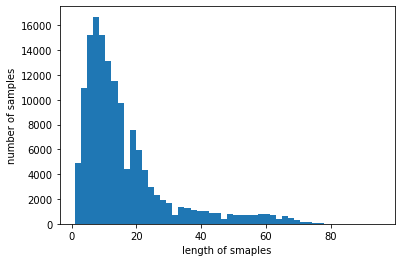

In [58]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of smaples')
plt.ylabel('number of samples')
plt.show()

In [59]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=60)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=60)

**Model**

In [60]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 100),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2226500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,270,853
Trainable params: 2,270,853
Non-trainable params: 0
_________________________________________________________________


WIthout GPU:
Epoch 1/15
1939/1939 [==============================] - 292s 149ms/step - loss: 0.4593 - acc: 0.7771 - val_loss: 0.3589 - val_acc: 0.8383

In [61]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [62]:
history = model.fit(X_train, y_train, 
                    batch_size=60,
                    validation_split=0.2,
                    epochs=15)

Epoch 1/15
1939/1939 [==============================] - 27s 13ms/step - loss: 0.4435 - acc: 0.7874 - val_loss: 0.3536 - val_acc: 0.8416
Epoch 2/15
1939/1939 [==============================] - 27s 14ms/step - loss: 0.3279 - acc: 0.8562 - val_loss: 0.3538 - val_acc: 0.8375
Epoch 3/15
1939/1939 [==============================] - 27s 14ms/step - loss: 0.2952 - acc: 0.8741 - val_loss: 0.3285 - val_acc: 0.8570
Epoch 4/15
1939/1939 [==============================] - 27s 14ms/step - loss: 0.2745 - acc: 0.8851 - val_loss: 0.3252 - val_acc: 0.8613
Epoch 5/15
1939/1939 [==============================] - 26s 14ms/step - loss: 0.2550 - acc: 0.8960 - val_loss: 0.3277 - val_acc: 0.8603
Epoch 6/15
1939/1939 [==============================] - 26s 14ms/step - loss: 0.2391 - acc: 0.9037 - val_loss: 0.3270 - val_acc: 0.8575
Epoch 7/15
1939/1939 [==============================] - 26s 13ms/step - loss: 0.2251 - acc: 0.9107 - val_loss: 0.3372 - val_acc: 0.8598
Epoch 8/15
1939/1939 [==========================

In [63]:
model.evaluate(X_test, y_test)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.4296 - acc: 0.8433


[0.42963796854019165, 0.8433021903038025]

**Visualization**

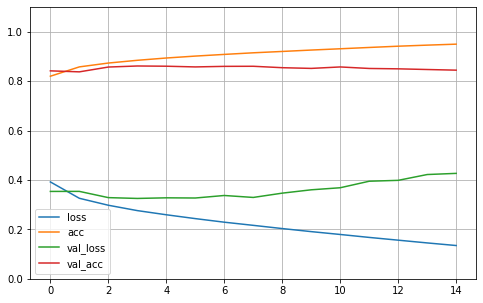

In [64]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1.1)
plt.show()

**Predict**
https://movie.naver.com/movie/bi/mi/point.nhn?code=189075#pointExpertTab

In [65]:
def predict(sentence):
  token = [word for word in mecab.morphs(sentence)]
  sequences = tokenizer.texts_to_sequences([token])
  pad = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=60)
  score = float(model.predict(pad))
  if score > 0.5:
    print("{} \n -> Positive {:.2f}%".format(sentence, score*100))
  else:
    print("{} \n -> Negative {:.2f}%".format(sentence, (1-score)*100))

In [67]:
predict('근래에 봤던 영화 중에 가장 깊은 감동이 있네요.보고 나온 이후에도 여운이 길어서 많은분들께 추천해드리고싶습니다. \
연출 배우님들 참 멋지고 좋습니다.')

근래에 봤던 영화 중에 가장 깊은 감동이 있네요.보고 나온 이후에도 여운이 길어서 많은분들께 추천해드리고싶습니다. 연출 배우님들 참 멋지고 좋습니다. 
 -> Positive 99.88%


In [68]:
predict('흑백영화라 사실 왜 흑백으로 했을까 생각했었는데 영화를 끝까지 다보고 난 뒤 이준익 감독님의 소름돋는 연출력을 느낄수 있었습니다 \
오랜만에 눈물도 흘리고 넘 재밌게 본 영화네요 개인적으로 한국사공부하면서 정약전에 대해 알고 있어서 더 흥미롭게 봤던거같아요')

흑백영화라 사실 왜 흑백으로 했을까 생각했었는데 영화를 끝까지 다보고 난 뒤 이준익 감독님의 소름돋는 연출력을 느낄수 있었습니다 오랜만에 눈물도 흘리고 넘 재밌게 본 영화네요 개인적으로 한국사공부하면서 정약전에 대해 알고 있어서 더 흥미롭게 봤던거같아요 
 -> Positive 99.98%


In [69]:
predict('마침 최근 강진군 여행시 다산의 흔적을 보고 왔는데영화에서 다산과 자산의 애틋한 형제애가 따뜻해 보인다\
배우들의 연기력도 좋고 바다를 배경으로 한 영상미가 뛰어났다')

마침 최근 강진군 여행시 다산의 흔적을 보고 왔는데영화에서 다산과 자산의 애틋한 형제애가 따뜻해 보인다배우들의 연기력도 좋고 바다를 배경으로 한 영상미가 뛰어났다 
 -> Positive 99.94%


In [70]:
predict(' 살짝 지루한 면도 있지만 보길 잘했다 싶어요~ 흑백의 영상 넘 좋아요.')

 살짝 지루한 면도 있지만 보길 잘했다 싶어요~ 흑백의 영상 넘 좋아요. 
 -> Positive 99.90%
